# Лабораторна робота 1

### Шифр Вiженера. Частотний криптоаналiз

Розглядаються тексти українською мовою. При аналiзi текстiв пробiли, цифри та
знаки пунктуацiї iгноруються. Мiнiмальна довжина ключа — 5, максимальна — 20.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
from pylab import rcParams
import random
import math

# Джерела
# http://practicalcryptography.com/cryptanalysis/text-characterisation/chi-squared-statistic/
# http://practicalcryptography.com/cryptanalysis/stochastic-searching/cryptanalysis-vigenere-cipher/
# https://en.wikipedia.org/wiki/Index_of_coincidence

**Завдання 1.** Побудуйте гiстограму частот появи лiтер в текстi.

In [2]:
text1 = open("book1.txt", "r").read() 
text1[:1000]  # приклад тексту 1

'              О. М. АВРАМЕНКО\n\n\n\n\n       УКРАЇНСЬКА\n       ЛІТЕРАТУРА\n           Підручник для 6 класу\n    загальноосвітніх навчальних закладів\n\nРекомендовано Міністерством освіти і науки України\n\n\n\n\n                      Київ\n                    «Грамота»\n                      2014\n\x0c      УДК 373.5:821.161.2.09.+821.161.2.09] (075.3)\n      Б Б К 83.3(4Укр)я721\n           А21\n\n                      Рекомендовано Міністерством освіти і науки України\n                        (наказ М ОН України від 07.02. 2014 р. № 123)\n\n              В и д ано з а р а х у н о к д е р ж а вн и х к о ш т ів . П родаж за б о р о н ен о\n\nН аукову експертизу проводив Інститут літератури ім. Т. Г. Шевченка НАН України.\nПсихолого-педагогічну експертизу проводив Інститут педагогіки НАПН України.\nЕксперт и, я кі здійсню вали експерт изу: О. О. Матвеева, молодший науковий співро\xad\nбітник Інституту літератури ім. Т. Г. Ш евченка НАН України; С. П. Паламар, старший\nнауковий співр

In [3]:
alphabet = "абвгґдеєжзиіїйклмнопрстуфхцчшщьюя"
punсt = "!()-[]{};?@#$%:'\"\,./^&amp;*_ "

In [4]:
def clear_text(text):
    """ 
        З тексту видаляються всі розділові знаки, пробіли, літери переводяться в нижній регістр. 
    """
    return "".join([s.lower() for s in text if s.lower() in alphabet])

In [5]:
#text1 = clear_text(text1)
#text1[:1000]

In [6]:
def num_of_letters(text):
    """
        Допоміжна функція, яка рахує кількість літер в тексті, тобто
        символів, які треба зашифрувати.
    """
    return sum([1 for s in text if s.lower() in alphabet])

In [7]:
def get_frequencies(text):
    """ Функція повертає список кортежів, де на першому місці стоїть літера, 
        на другому - частота її появи в тексті. 
    """   
    frequencies = dict()
    for s in list(alphabet):
        frequencies.update({s: 0})
    
    for s in text:
        if s.lower() in alphabet:
            frequencies[s.lower()] += 1
            
    N = num_of_letters(text)
    
    for k, v in frequencies.items():
        frequencies[k] = v / N
        
    return sorted(frequencies.items(), key=lambda x: -x[1])

In [8]:
frequencies1 = get_frequencies(text1)
frequencies1

[('о', 0.09268153021784468),
 ('а', 0.08692735422988074),
 ('и', 0.06797787028122483),
 ('н', 0.06008482497480794),
 ('в', 0.0572863306040762),
 ('і', 0.05371874149153855),
 ('т', 0.04973572894182107),
 ('е', 0.046019373328131184),
 ('р', 0.04507905676424439),
 ('с', 0.04083500110873147),
 ('к', 0.040644130880838035),
 ('л', 0.03652638640554871),
 ('у', 0.035979037957913115),
 ('д', 0.032439517996536264),
 ('м', 0.031412187064050995),
 ('п', 0.028523871409604704),
 ('я', 0.024916985485441936),
 ('з', 0.023134594386731152),
 ('б', 0.01862388179519063),
 ('ь', 0.018132671649876635),
 ('г', 0.01636712204186233),
 ('й', 0.01546890920471674),
 ('ч', 0.014163693675739553),
 ('х', 0.01113222535037318),
 ('ж', 0.009754030028377911),
 ('ю', 0.008538635783115282),
 ('ш', 0.008417938433123844),
 ('ц', 0.00768533358782697),
 ('щ', 0.005692423855410188),
 ('ї', 0.005257352012417792),
 ('є', 0.004884032301979156),
 ('ф', 0.001866598552193183),
 ('ґ', 9.262819883063916e-05)]

In [9]:
def visualize_frequencies(frequencies, sort=True):  
    """
        Функція будує гістограму частот появи літер в тексті.
            - якщо sort=True, то гістограма будується за спаданням частоти;
            - якщо sort=False, то за алфавітом.
    """
    if sort:
        index = [c[0] for c in frequencies]
        values = [c[1] for c in frequencies]
    else:
        index = list(alphabet)
        values = []
        for i in range(33):
            for c in frequencies:
                if c[0] == index[i]:
                    values.append(c[1])
                    break
                
    plt.bar(index, values, color="blue")
    plt.title("Частоти появи лiтер в текстi", fontweight="bold", fontsize=18)
    rcParams['figure.figsize'] = 12, 6
    
    plt.show()

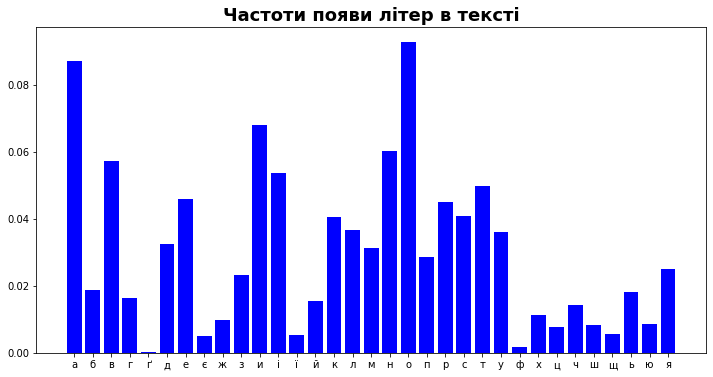

In [11]:
visualize_frequencies(frequencies1, False)

**Завдання 2.** Реалiзуйте алгоритм шифрування Вiженера.

In [12]:
# ключ складається тільки з літер в нижньому регістрі

def encrypt_Vigenere(plaintext, key):
    """
        Функція шифрує текст за алгоритмом Віженера.
    """
    ciphertext = ""
    i = 0  # вказівник по літерах - костиль виник, коли треба було вирішити задачу невидаляння розділових знаків з тексту
    j = 0  # вказівник по всіх символах тексту
    while j < len(plaintext): 
        a = plaintext[j]
        if a.lower() in alphabet:
            b = key[i % len(key)]
            a_ind = alphabet.index(a.lower())
            b_ind = alphabet.index(b)
            c_ind = (a_ind + b_ind) % 33
            c = alphabet[c_ind]
            if a == a.upper():  # зберігаємо регістр літер
                c = c.upper()
            ciphertext += c
            i += 1
        else:
            ciphertext += a
        j += 1
        
    return ciphertext



def decrypt_Vigenere(ciphertext, key):
    """
        Функція розшифровує текст за алгоритмом Віженера.
    """
    plaintext = ""    
    i = 0
    j = 0
    while j < len(ciphertext):
        a = ciphertext[j]
        if a.lower() in alphabet:
            b = key[i % len(key)]
            a_ind = alphabet.index(a.lower()) 
            b_ind = alphabet.index(b)
            c_ind = (a_ind - b_ind) % 33
            c = alphabet[c_ind]
            if a == a.upper():  
                c = c.upper()
            plaintext += c
            i += 1
        else:
            plaintext += a        
        j += 1
        
    return plaintext

In [13]:
def check_correctness(text, decrypted_text):
    """
        Допоміжна функція, показує чи правильно ми зашифрували/розшифрували текст.
    """
    if text == decrypted_text:
        print("\nРозкодований текст повністю співпадає з початковим!")
    else:
        print("\nПід час шифрування/дешифрування сталась помилка :(")

In [14]:
# Перевірка

key_1 = "привіт"
text_1 = "УКРАЇНСЬКА ЛІТЕРАТУРА \tПідручник для 6 класу\nзагальноосвітніх навчальних закладів."

print("\t\tЗакодований шифром Віженера текст:")
encrypted_text_1 = encrypt_Vigenere(text_1, key_1)
print(encrypted_text_1)

print("\n\t\tРозкодований текст:")
decrypted_text_1 = decrypt_Vigenere(encrypted_text_1, key_1)
print(decrypted_text_1)

check_correctness(text_1, decrypted_text_1)

		Закодований шифром Віженера текст:
ЗБЬВУЕЄНФВ ЦАЖЦЬВАЇЕР 	Щймззкчїх чбп 6 фніиз
щидіґмґшряфьзчйг ептґвцпгьв іігбрлйй.

		Розкодований текст:
УКРАЇНСЬКА ЛІТЕРАТУРА 	Підручник для 6 класу
загальноосвітніх навчальних закладів.

Розкодований текст повністю співпадає з початковим!


In [15]:
def encrypt_file(fname1, fname2, key):
    """
        Шифруємо текст файлу fname1 та записуємо його в новий файл fname2.
    """
    with open(fname1, "r") as f1:
        text = f1.read()
        with open(fname2, "w") as f2:
            f2.write(encrypt_Vigenere(text, key))
            

def decrypt_file(fname1, fname2, key):
    """
        Розшифровуємо текст файлу fname1 та записуємо його в новий файл fname2.
    """
    with open(fname1, "r") as f1:
        text = f1.read()
        with open(fname2, "w") as f2:
            f2.write(decrypt_Vigenere(text, key))

In [16]:
# зашифруємо весь текст файлу "book1.txt" та запишемо в окремий файл "encrypted_book1.txt"

key1 = "криптографія"
encrypt_file("book1.txt", "encrypted_book1.txt", key1)

**Завдання 3.** Проведiть криптоаналiз шифру Вiженера i розшифруйте запропонований крипто-текст, не знаючи секретного ключа.

In [17]:
# вважатимемо частоти появи літер в тексті, отримані в завданні 1 є "правильними"

def generate_key():
    """ Функція генерує випадковий ключ довжини від 5 до 20 символів. """
    alphabet = "абвгґдеєжзиіїйклмнопрстуфхцчшщьюя"
    length = random.randint(5, 20)
    key = ""
    return "".join(random.choice(alphabet) for i in range(length))

In [18]:
# нехай заданий криптотекст - зашифрована "book2.txt"
text2 = open("book2.txt", "r").read() 
key2 = generate_key()
encrypted_text2 = encrypt_Vigenere(text2, key2)

# очищені дані зручніше аналізувати
clean_encrypted_text2 = clear_text(encrypted_text2)  

In [19]:
key2  # за умовою ми не знаємо цей ключ

'кьщвцччтвсшєн'

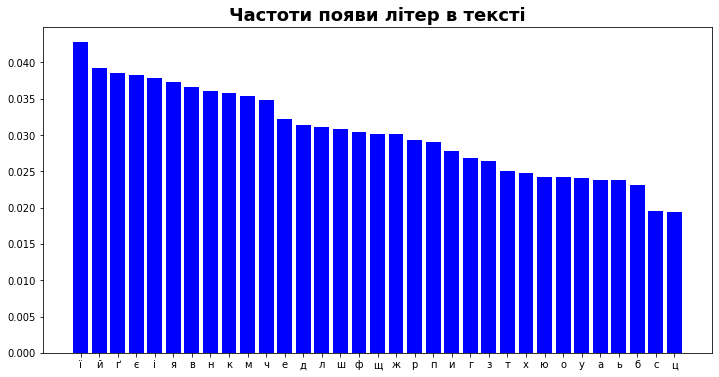

In [20]:
frequencies2 = get_frequencies(encrypted_text2)
visualize_frequencies(frequencies2)

На цій гістограмі частоти розподілені більш рівномірно, ніж на попередній. Отже аналіз монограм буде не дуже ефективним. 

In [21]:
# Для початку визначимо довжину ключа
# Для цього скористаємось індексом співпадіння (the index of coincidence)


def IC(text):
    """
        The index of coincidence provides a measure of how likely it is to 
        draw two matching letters by randomly selecting two letters from a given text.
    """
    c = 33
    N = len(text)
    S = 0
    for i in range(33):
        ni = text.count(alphabet[i])
        S += (ni / N) * ((ni - 1) / (N - 1))
    return c * S


def average(lst):
    return sum(lst) / len(lst)


def best_lengths(text):  
    """
        Функція повертає список кортежів, в яких на першій позиції - ймовірна довжина ключа,
        на другій - її IC-value. Чим більше IC-value, тим ймовірніше, що ключ має таку довжину.
    """
    ICs = dict()
    for i in range(5, 21):
        ic = []
        N = len(text)
        for j in range(i):
            subtext = "".join([text[i*k + j] for k in range(len(text) // i)])
            ic.append(IC(subtext))
        ICs.update({str(i): average(ic)})
        
    ans = sorted(ICs.items(), key=lambda x: -x[1])
    print("Найімовірніше ключ має довжину {}.".format(ans[0][0]))
    return ans

In [22]:
key_length = best_lengths(clean_encrypted_text2)

Найімовірніше ключ має довжину 13.


In [23]:
# знайдемо ймовірний ключ довжини 13

def chi_square(text):
    """
        The Chi-squared statistic, which compare the frequency distribution of our 
        subsequences to the expected frequency distribution (використовуємо значення
        частот, отримані в завданні 1).
    """
    global frequencies1
    S = 0
    for i in range(33):
        Ci = text.count(alphabet[i])
        fr = [v for k, v in frequencies1 if k == alphabet[i]][0]
        Ei = fr * len(text)
        S += math.pow(Ci - Ei, 2) / Ei
    return S


def find_key(text, i):
    """
        We try deciphering text with each of the 33 possible Caesar ciphers, 
        and compare the frequency distribution of the deciphered text with the 
        frequency distribution of Ukrainian for each key.
    """
    key = ""
    for j in range(i):
        sequences = {}
        subtext = "".join([text[i*k + j] for k in range(len(text) // i)])
        for k in range(33):
            subtext1 = "".join([alphabet[(alphabet.index(s) - k) % 33] for s in subtext])
            chi = chi_square(subtext1)
            sequences.update({str(k): chi})
        min_chi = min(list(sequences.values()))
        s = [k for k, v in sequences.items() if v == min_chi][0]
        key += alphabet[int(s)]
    return key

In [24]:
find_key(clean_encrypted_text2, 13)

'кьщвцччтвсшєн'

In [25]:
# спробуємо розшифрувати за допомогою отриманого ключа

key = "кьщвцччтвсшєн"
decrypted_text2 = decrypt_Vigenere(encrypted_text2, key)
check_correctness(text2, decrypted_text2)


Розкодований текст повністю співпадає з початковим!
